# TRIÈST: Counting Local and Global Triangles in Graphs

TRIEST is a streaming algorithm that computes an unbiased, low-variance and reliable approximation of the global and local number of triangles in a given graph. The algorithm is presented in the paper : **TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size**

Three different algorithms is proposed the first two use a simple version of reservoir sampling that is based on insertion-only and the third is fully-dynamic and support both insertions and deletions in adversarial manner. 


This report will on focus on the first two variant namely : TRIESTbase and TRIESTimpr. For further details read the article  Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size. 

## Reservoid sampling

Reservoir sampling is a simple sampling that is nonetheless very effective and is used extensively in streaming algorithms. Especially when we need to estimates the number of coming in a stream but we can not store all the element in the stream. 
A good starting point in order to fully understand the reservoir sampling algorithm is the article **Exponential Reservoir Sampling for Streaming Language Models**. 

The following python code shows a simple reservoir sampling :

In [1]:
import numpy as np 

def reservoirSampling(k, stream) :
    # Initialize an empty reservoir (any containerdata type).
    reservoir = list(np.zeros(k))
    n = 0
    
    for item in stream :
        if n < k :
            # print("n : ", n)
            reservoir[n] = item 
        elif flipBiasedCoin(n/k) :
            random_k = np.random.randint(k, size=1)[0]
            reservoir[random_k] = item
        n = n + 1
    
    return reservoir
            
def flipBiasedCoin(prob_heads=.5) :
    turn = np.random.uniform(0,1)
    return turn < prob_heads 

We will use it to estimate the counts

In [3]:
N = 100
k = 9
streams = [ flipBiasedCoin(0.6) for i in range(N)]
size_stream = 10
estimates = float(streams.count(True))
print("True estimates : ", estimates)
count = 0
for j in range(int(N/size_stream)) :
    j_start = j*size_stream;
    j_end = (j+1)*size_stream;
    stream = streams[j_start:j_end]
    samples = reservoirSampling(k, stream)
    count += float(samples.count(True))

print("Apprx estimates : ", count)

True estimates :  61.0
Apprx estimates :  55.0


In [4]:
N = 100
k = 10
streams = [ flipBiasedCoin(0.6) for i in range(N)]
size_stream = 10
estimates = float(streams.count(True))
print("True estimates : ", estimates)
count = 0
for j in range(int(N/size_stream)) :
    j_start = j*size_stream;
    j_end = (j+1)*size_stream;
    stream = streams[j_start:j_end]
    samples = reservoirSampling(k, stream)
    count += float(samples.count(True))

print("Apprx estimates : ", count)

True estimates :  60.0
Apprx estimates :  60.0


## The TRIEST base algorithm

In [5]:
import numpy as np
import math 
import itertools 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class TriestBase:
    """A simple attempt to model a dog.""" 
    def __init__(self,index, reservoirSize):

        self.M = reservoirSize
        self.data, self.NumberOfEdges, self.NumberOfNodes, self.triangleCount = self.readDataForStats(index)
        self.S = nx.Graph()
        self.KK_global = [0]*(self.NumberOfNodes + 2)
        self.t = 0
        self.index = index
        self.results = [] 
        
    def readData(self, index = 3) :
        data1 = 'lesMiserables.txt'
        data2 = 'mmorenot_train.txt'
        data3 = 'morino_beach.txt'
        data4 = 'euroroad.txt'
        data = [data1, data2, data3, data4] 
        dat = np.loadtxt(data[index])
        return dat[2:], int(dat[1][0]), int(dat[1][1])

    def readDataForStats(self,index = 3) :
        data1 = 'lesMiserables.txt'
        data2 = 'mmorenot_train.txt'
        data3 = 'morino_beach.txt'
        data4 = 'euroroad.txt'
        data = [data1, data2, data3, data4] 
        dat = np.loadtxt(data[index])
        triangleCount = int(dat[0][0])
        return dat[2:], int(dat[1][0]), int(dat[1][1]), triangleCount

    def graph_data(self) :
        g = nx.Graph()
        for x in self.data :
            from_node = x[0]
            to_node = x[1]
            g.add_edges_from([(int(from_node), int(to_node))])
            
        nx.draw_networkx(g, node_color='blue') 
        plt.show()
    
        return 0
    
    def triest_base(self) :
        
        for element in self.data :
            self.t = self.t + 1
            from_node, to_node = element[0], element[1]
            if self.sampleEdge() :
                self.S.add_edges_from([(int(from_node), int(to_node))])
                self.updateCounters('+', (int(from_node), int(to_node))) 
                self.results.append(self.KK_global[-1])
    
        return self.KK_global, self.t
        
    def sampleEdge(self) :
        
        if self.t <= self.M :
            return True 
        elif self.flipBiasedCoin(self.M / self.t) :
            NumberOfEdges = self.S.number_of_edges()
            edgeNumber = np.random.randint(NumberOfEdges, size=1)[0]
            all_edges = self.S.edges()
            randomEdge = all_edges[edgeNumber]
            (u,v) = randomEdge
            self.S.remove_edge(u,v)
            self.updateCounters('-', randomEdge)
            return True 
            
        return False 
        
    def flipBiasedCoin(self, prob_heads=.5) :
        turn = np.random.uniform(0,1)
        return turn < prob_heads 
        
    def updateCounters(self,  sign, randomEdge) :
        
        (u,v) = randomEdge
        N_uS = set(self.S.neighbors(u))
        N_vS = set(self.S.neighbors(v))
        N_uvS = N_uS.intersection(N_vS)
        N_uvS = list(N_uvS)
        valor = len(N_uvS)
        if sign == '+' :
            self.KK_global[-1] = self.KK_global[-1] + valor
            self.KK_global[u] = self.KK_global[u] + valor
            self.KK_global[v] = self.KK_global[v] + valor
            for c in N_uvS :
                self.KK_global[c] = self.KK_global[c] + 1
        else :
            self.KK_global[-1] = self.KK_global[-1] - valor
            self.KK_global[u] = self.KK_global[u] - valor
            self.KK_global[v] = self.KK_global[v] - valor
            for c in N_uvS :
                self.KK_global[c] = self.KK_global[c] - 1
                
        return self.KK_global
        
    def estimateTriangles(self) :
        r = (self.t * (self.t-1)*(self.t-2)) / (self.M *(self.M -1)*(self.M -2))
        r = max(1,r)
        
        return r * self.KK_global[-1]


    def reInit(self, reservoirSize):

        self.M = reservoirSize
        self.S = nx.Graph()
        self.KK_global = [0]*(self.NumberOfNodes + 2)
        self.t = 0
        self.results = [] 

def TriestBasemakeStatistics(index = 2) :

    
    Triest = TriestBase(index = index, reservoirSize = 300)
    triangleCount = Triest.triangleCount
    data_size = Triest.NumberOfEdges
    minimun = data_size - 100
    maximum = data_size + 10
    M = list(np.arange(minimun ,maximum))
    
    estimates = [] 

    for reservoirsize in M :
        Triest.reInit(reservoirsize)
        Triest.triest_base()
        estimates.append(Triest.estimateTriangles()) 
        
    length = len(estimates) 
    correct = [triangleCount]*length
    
    plt.figure()
    plt.plot(M, estimates, 'k',label='Estimation', linewidth=0.5)
    plt.plot(M, correct,'b' ,label='Correct')
    plt.plot(data_size,triangleCount, 'ro', label='t <= M')
    plt.legend( loc='best')
    plt.xlabel("M - reservoir size ")
    plt.ylabel("Triangle count estimation")
    plt.title('TriestBase for data ' + str(index))
    plt.savefig("TriestBaseForData" + str(index) +  ".png")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show() 
    
    
    return np.var(estimates)    

## The TRIESTImpr algorithm 

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class TriestImproved:
    """A simple attempt to model a dog.""" 
    def __init__(self,index, reservoirSize):

        self.M = reservoirSize
        self.data, self.NumberOfEdges, self.NumberOfNodes, self.triangleCount = self.readDataForStats(index)
        self.S = nx.Graph()
        self.KK_global = [0]*(self.NumberOfNodes + 2)
        self.t = 0
        self.index = index
        self.results = [] 
        
    def readData(self, index = 3) :
        data1 = 'lesMiserables.txt'
        data2 = 'mmorenot_train.txt'
        data3 = 'morino_beach.txt'
        data4 = 'euroroad.txt'
        data5 = 'exampleData.txt'
        data = [data1, data2, data3, data4, data5] 
        dat = np.loadtxt(data[index])
        return dat[2:], int(dat[1][0]), int(dat[1][1])

    def readDataForStats(self,index = 3) :
        data1 = 'lesMiserables.txt'
        data2 = 'mmorenot_train.txt'
        data3 = 'morino_beach.txt'
        data4 = 'euroroad.txt'
        data5 = 'exampleData.txt'
        data = [data1, data2, data3, data4, data5] 
        dat = np.loadtxt(data[index])
        triangleCount = int(dat[0][0])
        return dat[2:], int(dat[1][0]), int(dat[1][1]), triangleCount

    def graph_data(self) :
        g = nx.Graph()
        for x in self.data :
            from_node = x[0]
            to_node = x[1]
            g.add_edges_from([(int(from_node), int(to_node))])
            
        nx.draw_networkx(g, node_color='blue') 
        plt.show()
    
        return 0
    
    def triest_base(self) :
        
        
        for element in self.data :
            self.t = self.t + 1
            from_node, to_node = element[0], element[1]
            e = (int(from_node), int(to_node))

            
            if self.sampleEdge() :
                # print("+ true")
                self.S.add_edges_from([(int(from_node), int(to_node))])
            # First change
            if self.S.has_edge(*e) :
                self.updateCounters('+', (int(from_node), int(to_node))) 
                self.results.append(self.KK_global[-1])

    
        return self.KK_global, self.t
        
    def sampleEdge(self) :
        
        if self.t <= self.M :
            return True 
        elif self.flipBiasedCoin(self.M / self.t) :
            NumberOfEdges = self.S.number_of_edges()
            edgeNumber = np.random.randint(NumberOfEdges, size=1)[0]
            all_edges = self.S.edges()
            randomEdge = all_edges[edgeNumber]
            (u,v) = randomEdge
            self.S.remove_edge(u,v)
            # Second change
            # self.updateCounters('-', randomEdge)
            return True 
            
        return False 
        
    def flipBiasedCoin(self, prob_heads=.5) :
        turn = np.random.uniform(0,1)
        return turn < prob_heads 
        
    def updateCounters(self,  sign, randomEdge) :
        
        (u,v) = randomEdge
        N_uS = set(self.S.neighbors(u))
        N_vS = set(self.S.neighbors(v))
        N_uvS = N_uS.intersection(N_vS)
        N_uvS = list(N_uvS)
        valor = len(N_uvS)
        r = ((self.t-1)*(self.t-2)) / (self.M*(self.M-1))
        r = max(1,r)
        valor = valor*r
        
        if sign == '+' :
            self.KK_global[-1] = self.KK_global[-1] + valor
            self.KK_global[u] = self.KK_global[u] + valor
            self.KK_global[v] = self.KK_global[v] + valor
            for c in N_uvS :
                self.KK_global[c] = self.KK_global[c] + r

                
        return self.KK_global
        
    def estimateTriangles(self) :
        return self.KK_global[-1]


    def reInit(self, reservoirSize):

        self.M = reservoirSize
        self.S = nx.Graph()
        self.KK_global = [0]*(self.NumberOfNodes + 2)
        self.t = 0
        self.results = [] 


def TriestImprMakeStatistics(index = 2) :

    
    Triest = TriestImproved(index = index, reservoirSize = 300)
    triangleCount = Triest.triangleCount
    data_size = Triest.NumberOfEdges
    minimun = data_size - 100
    maximum = data_size + 10
    M = list(np.arange(minimun ,maximum))
    
    estimates = [] 

    for reservoirsize in M :
        Triest.reInit(reservoirsize)
        Triest.triest_base()
        estimates.append(Triest.estimateTriangles()) 
        
        
        
    length = len(estimates) 
    correct = [triangleCount]*length
    
    plt.figure()
    plt.plot(M, estimates, 'k',label='Estimation', linewidth=0.5)
    plt.plot(M, correct,'b' ,label='Correct')
    plt.plot(data_size,triangleCount, 'ro', label='t <= M')
    plt.legend( loc='best')
    plt.xlabel("M - reservoir size ")
    plt.ylabel("Triangle count estimation")
    plt.title('TriestImproved for data ' + str(index))
    plt.savefig("TriestImprovedForData" + str(index) +  ".png")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show() 
    
    
    return np.var(estimates) 

## Data

The data is represented as a list of different edges :

In [7]:
def readData(index = 3) :
    data1 = 'lesMiserables.txt'
    data2 = 'mmorenot_train.txt'
    data3 = 'morino_beach.txt'
    data4 = 'euroroad.txt'
    data5 = 'exampleData.txt'
    data = [data1, data2, data3, data4, data5] 
    dat = np.loadtxt(data[index])
    return dat[2:], int(dat[1][0]), int(dat[1][1])

def graph_data(data) :
    g = nx.Graph()
    for x in data :
        from_node = x[0]
        to_node = x[1]
        g.add_edges_from([(int(from_node), int(to_node))])
    nx.draw_networkx(g, node_color='blue') 
    plt.show()

In [11]:
exampleData, nEdges, nNodes = readData(4)
print("Example Data : ")
print(exampleData)

Example Data : 
[[ 1.  2.]
 [ 2.  3.]
 [ 3.  7.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 5.  7.]
 [ 5.  8.]
 [ 5.  9.]
 [ 7.  8.]
 [ 7. 11.]
 [ 8.  9.]
 [ 8. 11.]
 [ 9. 10.]
 [11. 12.]
 [11. 13.]
 [12. 13.]
 [12. 14.]
 [13. 14.]
 [14. 15.]
 [14. 16.]]


C:\Users\ben\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\ben\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\ben\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


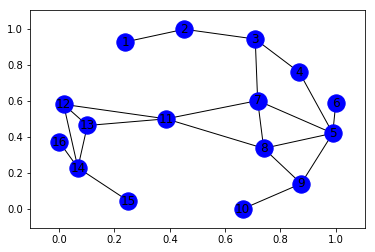

In [35]:
graph_data(exampleData)

We see from the graph above that the number of traingles is exactly 5. Let calculate it with our implemented algorithms

In [36]:
Triest = TriestImproved(index = 4, reservoirSize = 21)
Triest.triest_base()
print("Estimates = ", Triest.estimateTriangles())

Estimates =  5


The result seems accurate. 
Lets now use real data 

## Results

In [44]:
from triestImprovedClass import *
from triestBaseClass import *

def resultsForAllDatasets() :
    
    TriestBasemakeStatistics(index = 0)
    TriestImprMakeStatistics(index = 0)

    TriestBasemakeStatistics(index = 1)
    TriestImprMakeStatistics(index = 1)
    
    
    TriestBasemakeStatistics(index = 2)
    TriestImprMakeStatistics(index = 2)

    TriestBasemakeStatistics(index = 3)
    TriestImprMakeStatistics(index = 3)
    


def TestVariance(M = 200) :
    
    index = 0
    TriestA = TriestBase(index = index, reservoirSize = M)
    counter1, t1 = TriestA.triest_base()
    TriestB = TriestImproved(index = index, reservoirSize = M)
    counter2, t2 = TriestB.triest_base()
    variance1 = np.var(TriestA.results) 
    variance2 = np.var(TriestB.results)  
    print("variance1 : ", variance1)
    print("variance2 : ", variance2)
    print("TRIEST-BASE apprx 1 : ", counter1[-1])
    print("TRIEST-IMPROVED apprx 2 : ", counter2[-1])
    triangleCount = TriestA.triangleCount
    data_size = TriestA.NumberOfEdges
    # plt.figure()
    plt.plot(TriestA.results,'k',label='TriestBase', linewidth=0.8)
    # plt.xlabel("t")
    # plt.ylabel("Triangle count estimation")
    # plt.show()
    
    
    # plt.figure()
    plt.plot(TriestB.results,'r',label='TriestImproved')
    plt.plot(data_size,triangleCount, 'bo', label='Correct')
    plt.legend( loc='best')
    plt.title('Reservoir size ' + str(M))
    plt.xlabel("t")
    plt.ylabel("Triangle count estimation")
    plt.show()

variance1 :  7351.75557704601
variance2 :  13576.732044797185
TRIEST-BASE apprx 1 :  213
TRIEST-IMPROVED apprx 2 :  426.74120603015103


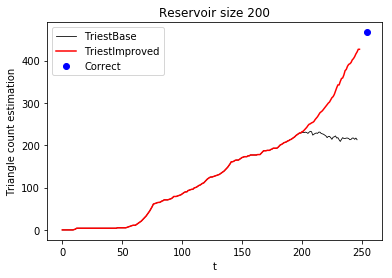

In [45]:
TestVariance(200)

The real number of count is exactly 467, lets increase the reservoir size such as t <= M

variance1 :  15668.626139252276
variance2 :  15668.626139252276
TRIEST-BASE apprx 1 :  467
TRIEST-IMPROVED apprx 2 :  467


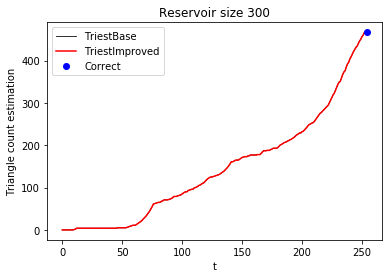

In [46]:
TestVariance(300)

When t <= M,  TRIEST-BASE and TRIEST-IMPROVED are exactly the same.

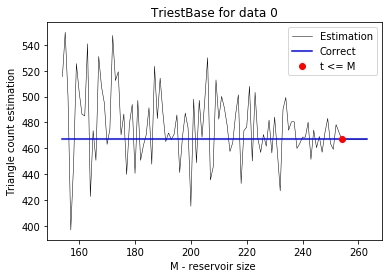

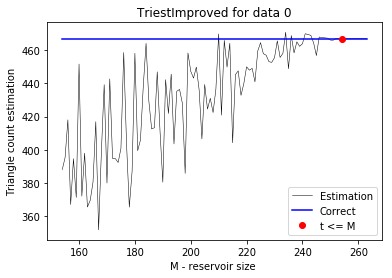

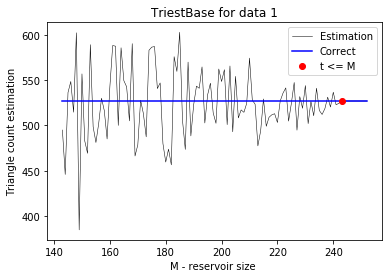

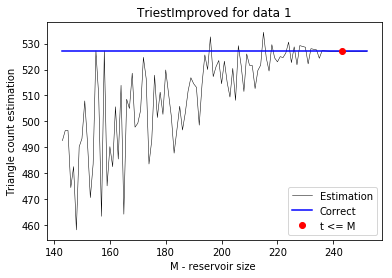

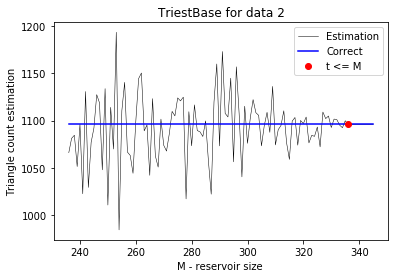

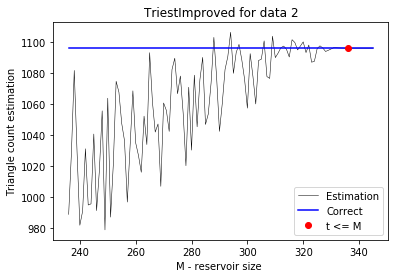

C:\Users\ben\Desktop\DataminingLabs\LAB3\triestBaseClass.py:107: RuntimeWarning: overflow encountered in long_scalars
  r = (self.t * (self.t-1)*(self.t-2)) / (self.M *(self.M -1)*(self.M -2))


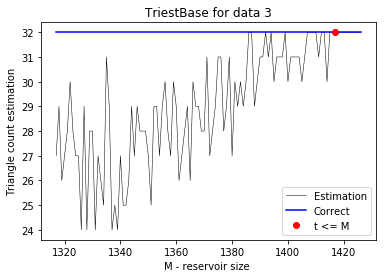

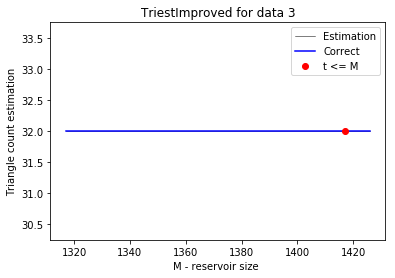

In [47]:
resultsForAllDatasets()